## Main Classes

In this notebook we will familiarize ourselves with the main classes of `cideMOD`. They will allow
us to have a better control over the different steps of the simulation, as well as, to configure
advance settings that cannot be done with `run_case`.

### Table of Contents
- Model options
- CellParser
- Problem
- Cell Simulation Interface

First we start by importing the main classes of `cideMOD`.

In [1]:
from cideMOD import (
    get_model_options,
    CellParser,
    Problem,
    CSI,
    Trigger,
    PlotView,
    VerbosityLevel,
    models_info
)

### Model options
The method `get_model_options` allows a fast configuration of the model used:
- `model` (`str`): Simulation model, default `P2D`, options `P2D`, `P3D`, `P4D` and `SPM`
- `solve_thermal` (`bool`): Whether to solve thermal problem or not, default False
- `solve_LAM` (`bool`): Whether to solve LAM problem or not, default False
- `SEI_model` (`str`): Which SEI model is active, default to None
- `N_x` (`int`): Discretization of every component in x direction, default 30
- `N_y` (`int`): Discretization in y direction, default 10
- `N_z` (`int`): Discretization in z direction, default 10
- `time_scheme` (`str`): Time discretization scheme, default `euler_implicit`.
- `raise_errors_on_exit` (`bool`): Whether to raise the `SolverCrashed` error on exit if it happens.
  Defaults to True.
- `clean_on_exit` (`bool`): Whether to clean from memory saved data at the end of the solve cycle.
  Defaults to True.
- `save_on_exit` (`bool`): Whether to save global variables on exit. They will be saved always
  before cleaning. Defaults to True.
- `save_path`: Path to the folder outputs. If it does not exist, create it. Otherwise it will check
  `overwrite` to override the existing data or change the given save_path
- `verbose`: Verbosity level. Defaults to `VerbosityLevel.BASIC_PROBLEM_INFO`. For more information
  type `help(VerbosityLevel)`

In [2]:
model_options = get_model_options(model='P2D', save_path="results/03_main_classes_discharge",
                                  clean_on_exit = False, verbose=VerbosityLevel.DETAILED_PROGRESS_INFO)

Saving results to /home/fenicsx/shared/cideMOD/examples/notebooks/results/results_03_main_classes_discharge


Each submodel may also have its own options. We can see the available options of an specific model. For the `PXD` model we have:

In [3]:
print(model_options.__doc__)


    Settings for the cideMOD's cell model simulation.

    General Parameters
    ------------------
    model: str
        Simulation mode, default "P2D"
    dimensionless: bool
        Whether to use the dimensionless version or not. Default to
        False
    solve_LAM: bool
        Whether to solve LAM problem or not. Default to False
    N_x: int
        Discretization in x direction. Default to 30
    N_y: int
        Discretization in y direction. Default to 10
    N_z: int
        Discretization in z direction. Default to 10
    FEM_order: int
        Order of interpolating finite elements. Default to 1
    time_scheme: str
        Time discretization scheme, default "euler_implicit"
    raise_errors_on_exit: bool
        Whether to raise the SolverCrashed error on exit if it happens.
        Default to True.
    clean_on_exit: bool
        Whether to clean from memory saved data at the end of the solve
        cycle. Default to True.
    save_on_exit: bool
        Whether t

### **CellParser**

The class `CellParser` parses and stores the cell properties from the input dictionary within a
python object. 

In [4]:
data_path = "../../data/data_Ai_2020"
cell_data = "params.json"
cell = CellParser(cell_data, data_path, model_options)

Negative electrode capacity: 0.071714
Positive electrode capacity: 0.071707
Cell capacity: 0.071707


This object allows the user to modify the values and flags of the selected parameter.

We can get the values of the different parameters by using `get_value`

In [5]:
L_a = cell.get_value('cell.anode.thickness')
eps_s_a0 = cell.get_value('cell.anode.am0.volume_fraction')

print(f"{L_a=}; {eps_s_a0=}")


L_a=7.65e-05; eps_s_a0=0.61


We can also update the values of the parameters by using `update_parameter/s`

In [6]:
cell.update_parameter('cell.anode.thickness', 80e-6)
print(f"L_a={cell.get_value('cell.anode.thickness')}")


Negative electrode capacity: 0.074995
Positive electrode capacity: 0.071707
Cell capacity: 0.071707
L_a=8e-05


### Problem

The class `Problem` is the core of the library. Having gathered the needed information, it builds the mathematical model, perform the simulation and store the requested data. First we have to initialize it:

In [7]:
problem = Problem(cell, model_options)

Building mesh for P2D problem with 5 components and 150 nodes
Finished mesh construction


Let's see some of its main functions.

`set_cell_state`: It sets the initial cell state. For the electrochemical model, we can set the
following parameters:
- `SoC`: Initial State of Charge of the battery cell.
- `T_ext`: External temperature in Kelvin.
- `T_ini`: Uniform value of the cell temperature.


In [8]:
T = 273.15 + 25  # temperature in K
problem.set_cell_state(SoC=1, T_ext=T, T_ini=T)


We can access the information of this method for each selected submodel as follows:

In [9]:
models_info('set_cell_state', model_options=model_options)



        Electrochemical
        ~~~~~~~~~~~~~~~
        This method set the current state of the cell.

        Parameters
        ----------
        problem: Problem
            Object that handles the battery cell simulation.
        SoC: float, optional
            Current State of Charge of the battery cell. Default initial
            value to 1.
        T_ext: float, optional
            External temperature. Default initial value to 298,15 K.
        T_ini: float, optional
            Uniform value of the internal temperature. Default initial
            value to `T_ext`.
        


`add_global_variables` and `add_internal_variables`: This methods allow us to include additional
outputs to be computed.

In [10]:
problem.add_global_variables('c_e_avg')
problem.add_internal_variables('ionic_current')

We can see the available outputs with

In [11]:
problem.print_available_outputs()

Available global variables: 'time' 'voltage' 'current' 'capacity' 'c_e_avg' 'phi_e_avg' 'phi_s_avg' 'i_Li_int_avg' 'i_Li_total_avg' 'cathode_SOC' 'total_lithium'
Available internal variables: 'c_e' 'phi_e' 'phi_s' 'i_Li_int' 'i_Li_total' 'j_Li_int_a' 'j_Li_int_c' 'j_Li_total_a' 'j_Li_total_c' 'overpotential_a' 'overpotential_c' 'ionic_current' 'electric_current' 'li_ion_flux' 'li_ion_flux_migration' 'li_ion_flux_diffusion' 'c_s_a_surf' 'c_s_a_avg' 'x_a_surf' 'x_a_avg' 'c_s_c_surf' 'c_s_c_avg' 'x_c_surf' 'x_c_avg'


`setup`: This method set up the Problem object. It performs the following actions:
1. Build the FEM function spaces
2. Build the cell properties
3. Set-up internal state variables
4. Set-up Warehouse object (to store the requested outputs)
5. Build the variational formulation

After this method is called, we cannot change any parameter or option that defines our simulation.

In [12]:
problem.setup()

Building problem setup
- Building FEM function spaces - Done
- Building cell parameters:
    Setting up 'cell' parameters
    Setting up 'cell.electrolyte' parameters
    Setting up 'cell.anode' parameters
    Setting up 'cell.anode.am0' parameters
    Setting up 'cell.cathode' parameters
    Setting up 'cell.cathode.am0' parameters
    Setting up 'cell.separator' parameters
    Setting up 'cell.negativeCC' parameters
    Setting up 'cell.positiveCC' parameters
- Building cell parameters - Done
- Initializing state - Done       
- Build variational formulation - Done 
- Building solvers - Done           


`solve`: Perform a simulation step. Either CC and CV are suported. Input parameters:

- `i_app`: The applied current in Amperes. If CV use None. Defaults to 30.0.
- `v_app`: The applied voltage in Volts. If CC use None. Defaults to None.
- `t_f`: The maximum duration of the simulation. Defaults to 3600.
- `store_delay`: The delay to apply between consecutive saves of the internal variables, in number
  of timesteps. Defaults to 1.
- `initial_step`: Initial timestep length. If not given, the timestep chose is the minimum.
  Defaults to None.
- `max_step`: Maximum timestep lenght for adaptive solver in seconds. Defaults to 3600.
- `min_step`: Minimum timestep lenght for adaptive solver in seconds. Defaults to 0.01.
- `triggers`: List of `Triggers` to check during runtime. Defaults to [].
- `adaptive`: Whether to use adaptive timestepping or not. Defaults to True.
- `time_adaptive_tol`: Tolerance of the time-adaptive scheme. Defaults to 1e-2

To define a trigger we can just use the class `Trigger`. Here is how to define a cut-off voltage of
3V:


In [13]:
v_min = Trigger(3, "v", mode='min')


We can see the available trigger variables

In [14]:
Trigger.print_available_variables()


Available trigger variables: 'time'('t'), 'voltage'('v'), 'current'('i')


Let's solve a 1C discharge until 3V or 3600 seconds

In [15]:
C_rate = -1
I_app = C_rate * cell.ref_capacity
t_f = 3600

status = problem.solve(min_step=10, i_app=I_app, t_f=t_f,
                       store_delay=10, triggers=[v_min])


Initializing solution
Solving ...
Reached max time 3600.00                          



Finally, we can plot the results using `PlotView` (only global variables, for internal variables use
`ParaView`)

In [16]:
PlotView(problem)

It is also possible to plot the global variables using standard python libraries like `matplotlib`.

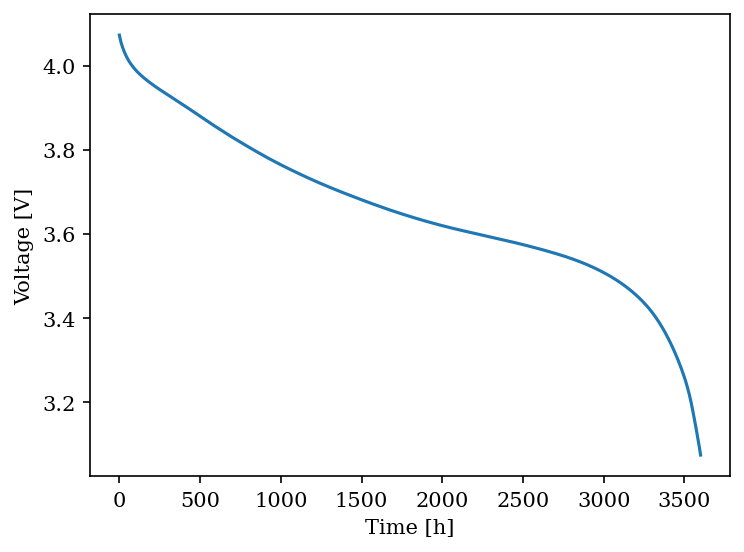

In [17]:
import matplotlib.pyplot as plt
plt.rc('font', family='serif')

# Plot voltage vs time
time = problem.get_global_variable('time')
voltage = problem.get_global_variable('voltage')
fig1, ax1 = plt.subplots(1, 1, figsize=(5.5, 4), dpi=150)
ax1.plot(time, voltage, "-", label='voltage')
ax1.set_xlabel("Time [h]")
ax1.set_ylabel("Voltage [V]")
plt.show()

Remember to set the model option `clean_on_exit` to `False` in order to do so. If you forgot to do
it, you could also read the global variables from the `.txt` generated in the results folder.

### **Cell Simulation Interface**
The `CSI` class allows the user to perform battery cell simulations with complex test plans. It is a high-level interface that configures and handles the `Problem` object for us. 

In [18]:
case = "Safari_2009"
model_options = get_model_options(model='P2D', save_path=f"results/03_main_classes_cycling",
                                  verbose=VerbosityLevel.BASIC_PROGRESS_INFO)

data_path = f"../../data/data_{case}"
cell_data = "params_cycling.json"
cell = CellParser(cell_data, data_path, model_options)

csi = CSI(cell, model_options, test_plan='cycling_protocol.json')

Let's see some of its main methods:

`setup`: Set up the `Problem` object, allowing the user to perform additional actions before running the simulation. It is an optional step.


In [19]:
csi.problem.add_global_variables('c_e_avg')
csi.setup()


`run_test_plan`: Execute the simulation.

In [20]:
csi.run_test_plan()

-- Cycle 'Cycling', iteration number 0 --
CC_Discharge: Apply -1.6977835724041341 A during 1 hours until [Voltage Trigger at 3 V]
Solving ...
Voltage is 3 V at 54min 20s                       

Pause: Rest during 15 minutes                     
Solving ...
Reached max time 4170.00                          

CC_Charge-CC: Apply 1.6977835724041341 A during 1 hours until [Voltage Trigger at 4.1 V]
Solving ...
Voltage is 4.1 V at 1h 10min 30s                  

CV_Charge-CV: Apply 4.1 V during 1 hours until [Current Trigger at 0.034 A]
Solving ...
Reached max time 7835.00                          

Pause: Rest during 15 minutes
Solving ...
Reached max time 8735.00                          

-- Cycle 'Cycling', iteration number 1 --
CC_Discharge: Apply -1.6977835724041341 A during 1 hours until [Voltage Trigger at 3 V]
Solving ...
Voltage is 3 V at 2h 54min 35s                     

Pause: Rest during 15 minutes                      
Solving ...
Reached max time 11385.00                    

`plot_global_results`: Generates an interactive plot with all the global variables.

In [21]:
csi.plot_global_results()